# Titanic: Machine Learning from Disaster

## 1. Checking Data
* 1.1 Categorical vs Numerical features


* 1.2 Data Description


* 1.3 About Missing Values


* 1.4 Checking Response(Target) Variable

## 2. Exploratory Data Analysis
* 2.1 Pclass


* 2.2 Sex


* 2.3 Embarked


* 2.4 Ticket


* 2.5 Cabin


* 2.6 Age


* 2.7 SibSp and Parch


* 2.8 Fare


* 2.9 Name

## 3. Filling Missing Values
* 3.1 Embarked


* 3.2 Age

## 4. Feature Engineering
* 4.1 Age feature to categorical


* 4.2 Fare feature to categorical


* 4.3 FamilySize feature to categorical


* 4.4 Sex feature


* 4.5 One - hot encoding for categorical features


* 4.6 Dropping unnecessary columns

## 5. Model Selection

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#loading data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
data=[train, test]

## 1. Checking Data

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.1  Categorical vs Numerical features

We can divide features into two groups; categorical and numerical features.

* Categorical: Pclass, Name, Sex, Ticket, Cabin, Embarked
   (Pclass is Ordinal)
* Numerical: Age, Fare, SibSp, Parch

### 1.2  Data Description

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


As seen above, there are total 891 observations, and 12 columns. Some values are null values, so we need to deal with null values. 

In [6]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Cairns, Mr. Alexander",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 1.3   About Missing Values

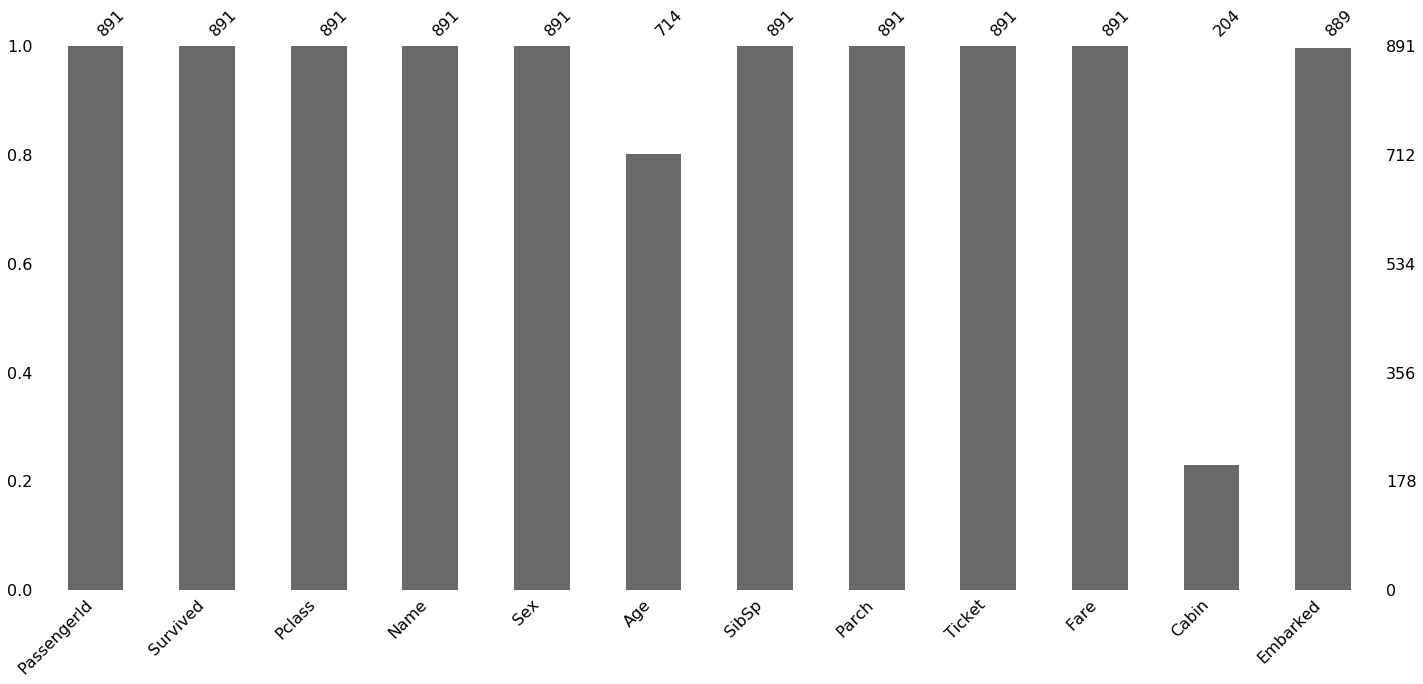

In [7]:
import missingno as msno

msno.bar(train)

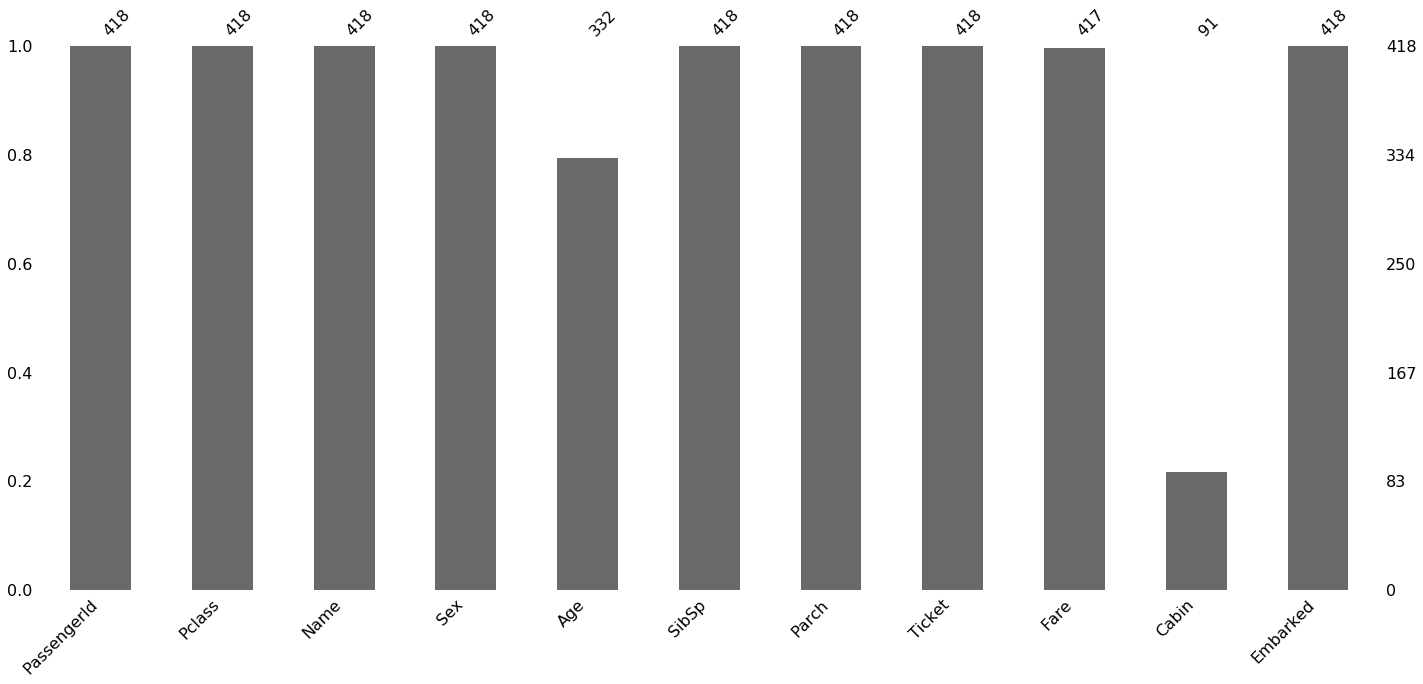

In [8]:
msno.bar(test)

#### Training Data
* There are two features which have quite a lot of missing values; Age and Cabin columns.
* Especially, it seems that it is hard to fill Cabin column's missing values, since around 80% of values are null. Thus, we will drop Cabin column later.
* Furthermore, 2 values of Embarked column were missing. Except above columns, non had missing values.

#### Test Data
* In test data, age and cabin columns had a lot of null values.
* One missing value in Fare column was detected.

In [9]:
#Set sns style
plt.style.use('seaborn')
sns.set(font_scale=1.5)

### 1.4  Checking Response(Target) Variable

* Checking target variable is important. In this problem, we need to predict whether the passenger survived or not. 
* Target Variable is 'Survived' in this problem.
* If target variable has skewed distribution, it can cause class imbalance problem.

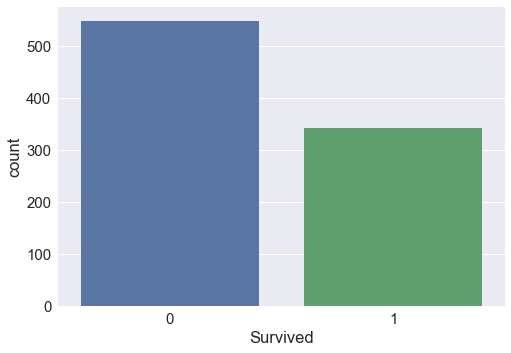

In [10]:
sns.countplot('Survived', data=train)

In [11]:
print(train['Survived'].value_counts(normalize=True))

0    0.616162
1    0.383838
Name: Survived, dtype: float64


* Around 38% of passengers in the training dataset survived. It seems that there will be no big influence from the class imbalanced problem, since the distribution is quite balanced.

## 2. Exploratory Data Analysis

### 2.1  Pclass

Text(0.5,1,'Dead/Survived count by Pclass')

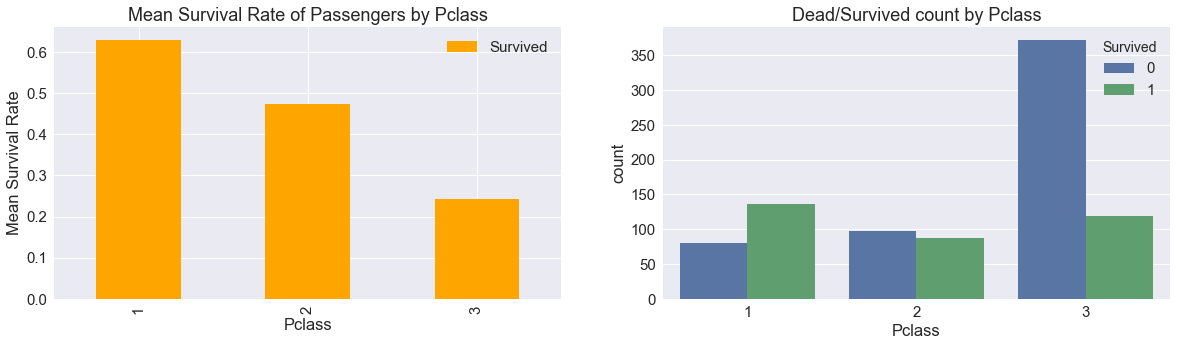

In [12]:
fig, ax=plt.subplots(1,2,figsize=(20,5))
(train[['Survived', 'Pclass']].groupby(['Pclass']).mean()).plot.bar(ax=ax[0], color='orange')
ax[0].set_title('Mean Survival Rate of Passengers by Pclass')
ax[0].set_ylabel('Mean Survival Rate')
sns.countplot('Pclass', hue='Survived', data=train, ax=ax[1])
ax[1].set_title('Dead/Survived count by Pclass')

* Mean Survival Rate of Passengers by Pclass differed from class 1 to class 3
* Passengers with higher class survived a lot, while passengers with lower class survived less.
* Pclass variable plays an significant role on predicting the target variable.

### 2.2  Sex

        Survived
Sex             
female  0.742038
male    0.188908


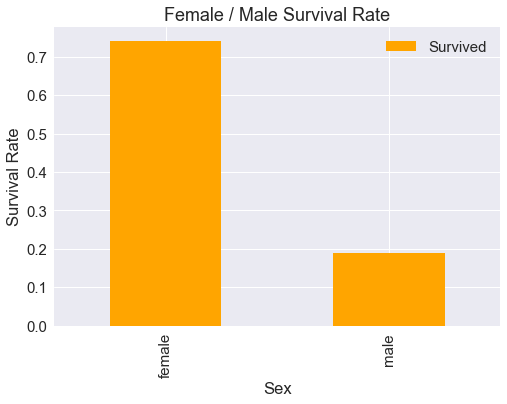

In [13]:
train[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(color='orange')
plt.title('Female / Male Survival Rate')
plt.ylabel('Survival Rate')

print(train[['Sex','Survived']].groupby(['Sex']).mean())

* There was a big difference between survival rate of female and male.
* Female survival rate was a lot higher than male survival rate.
* Sex is an important feature for the target variable.

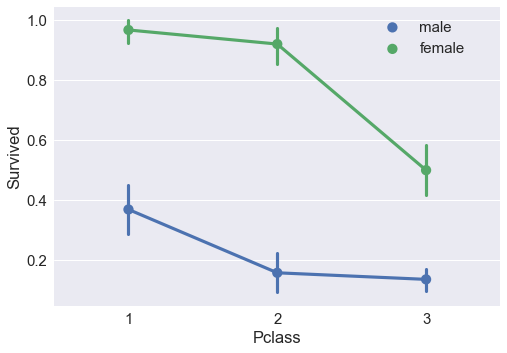

In [14]:
g=sns.pointplot('Pclass','Survived',hue='Sex',data=train)
g.legend(bbox_to_anchor=(0.95, 1), ncol=1)

* There was no exception. In all classes, female survival rate was much more higher than male survival rate.

### 2.3  Embarked

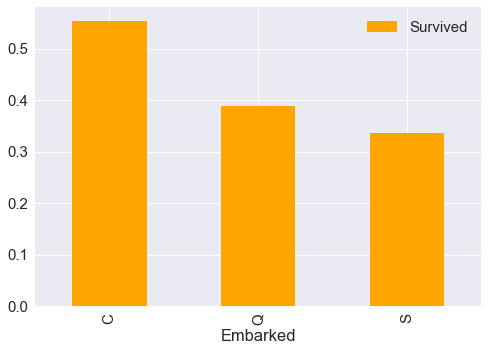

In [15]:
train[['Embarked','Survived']].groupby(['Embarked']).mean().plot.bar(color='orange')

* Passengers from Cherbourg(C) port had higher survival rate than passengers from other port.

Let's get deeper!

Text(0.5,1,'Pclass, Embarked Together')

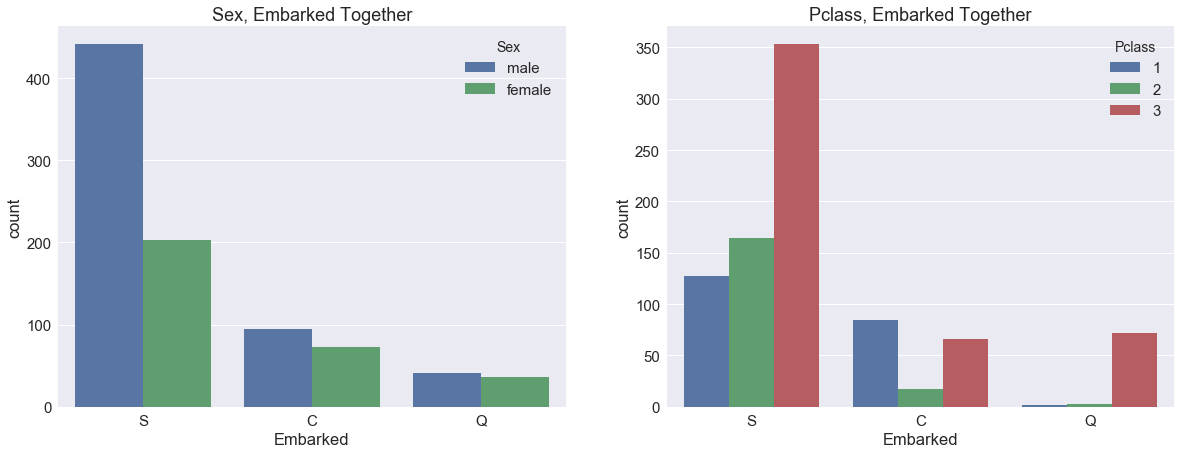

In [16]:
fig, ax=plt.subplots(1,2,figsize=(20,7))
sns.countplot('Embarked', hue='Sex',data=train, ax=ax[0])
ax[0].set_title('Sex, Embarked Together')
sns.countplot('Embarked',hue='Pclass',data=train, ax=ax[1])
ax[1].set_title('Pclass, Embarked Together')

From above two plots, we can say
* For C, Q, gender ratio was about 1, while S had more male passengers.
* Low survival rate of S port may be related with ratio of male passengers.


* 3rd class was the most prevalent for passengers from port S and Q.
* Passengers from port C were mostly in class 1, 3.
* Low survival rate of port S and high survival rate of port C may be related with class distribution in each port. 

### 2.4  Ticket

In [17]:
train['Ticket'].value_counts()

CA. 2343         7
347082           7
1601             7
3101295          6
347088           6
CA 2144          6
S.O.C. 14879     5
382652           5
17421            4
2666             4
19950            4
113760           4
PC 17757         4
347077           4
349909           4
W./C. 6608       4
113781           4
4133             4
LINE             4
248727           3
230080           3
347742           3
13502            3
110152           3
29106            3
F.C.C. 13529     3
SC/Paris 2123    3
363291           3
24160            3
C.A. 34651       3
                ..
SCO/W 1585       1
349228           1
7545             1
349221           1
2926             1
113804           1
374746           1
345780           1
335677           1
350036           1
374910           1
367229           1
349256           1
29011            1
112050           1
226875           1
4136             1
323951           1
368323           1
349244           1
111369           1
PC 17475    

It is hard to find specific patterns in ticket variable. Thus, I will drop this column later.

### 2.5  Cabin

In [18]:
train['Cabin'].isnull().sum()/len(train['Cabin'])

0.7710437710437711

* We already know that this variable has about 77% null values.
* It is hard to derive useful information.
* Thus, I will exclude this varialbe from my model.

### 2.6  Age

Text(0.5,0,'Age')

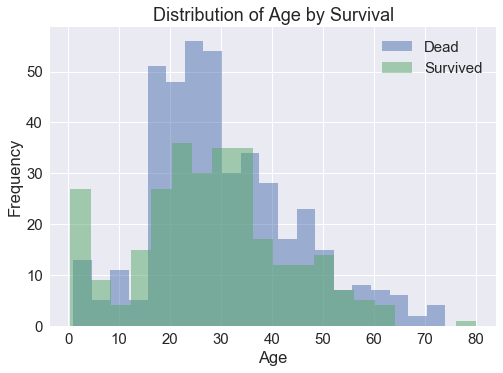

In [19]:
train.loc[train['Survived']==0,'Age'].plot.hist(bins=20, alpha=0.5)
train.loc[train['Survived']==1,'Age'].plot.hist(bins=20, alpha=0.5)
plt.legend(['Dead','Survived'])
plt.title('Distribution of Age by Survival')
plt.xlabel('Age')

We can find some interesting facts related to age.
* Infants, and children had high survival rate.
* Most passnegers were 15~35 years old.
* Large number of passengers whose age is over 20 did not survive.
* It would be better to divide age values into several intervals.

### 2.7  SibSp and Parch

* For SibSp and Parch, both variables are related to the number of family members. It would be better to combine two columns into one column.
* Our new column name is FamilySize, and it represents the number of family members.
* It can be derived by SibSp + Parch + 1. The reason we add 1 is to include passenger themselves.

In [20]:
for dataset in data:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1

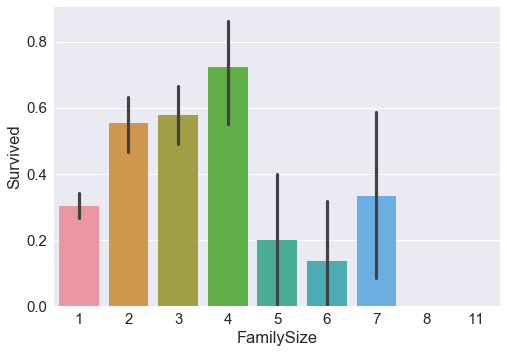

In [21]:
sns.barplot('FamilySize','Survived',data=train)

* Survival rate differed a lot by FamilySize.
* Single family and family with more than 5 members had low survival rate.
* Family with 2~4 members had higher survival rate.
* Family with 5~7 members had lower survival rate.

### 2.8  Fare

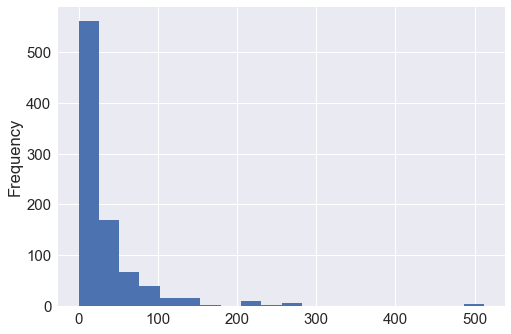

In [22]:
train['Fare'].plot.hist(bins=20)

* Fare variable is right-skewed. Skewness can lead to overweight high valued ourliers, causing bad performance. To fix this skewness, I will transform this values with log function.

* Before transformation, there is one missing value in the test data. We will fill this with the median value of the test data.

In [23]:
test['Fare']=test['Fare'].fillna(test['Fare'].median())

In [24]:
for dataset in data:
    dataset['Fare']=dataset['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

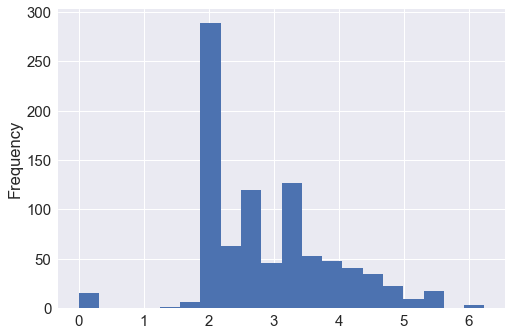

In [25]:
train['Fare'].plot.hist(bins=20)

After transformation, Fare column became less skewed.

Text(0.5,0,'Fare')

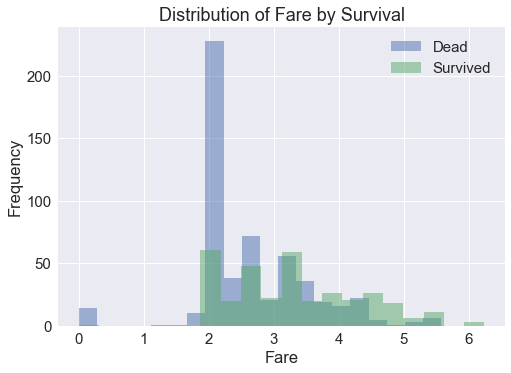

In [26]:
train.loc[train['Survived']==0,'Fare'].plot.hist(bins=20, alpha=0.5)
train.loc[train['Survived']==1,'Fare'].plot.hist(bins=20, alpha=0.5)
plt.legend(['Dead','Survived'])
plt.title('Distribution of Fare by Survival')
plt.xlabel('Fare')

* Survival rate of passengers with cheap ticket was lower than passengers with expensive ticket.
* Almost passengers with Fare smaller than 2 died. 
* Meanwhile, most passengers with Fare bigger than 4 survived.
* It looks like survival rates differ from the intervals. 

Text(0.5,1,'Survival rate by Fare intervals')

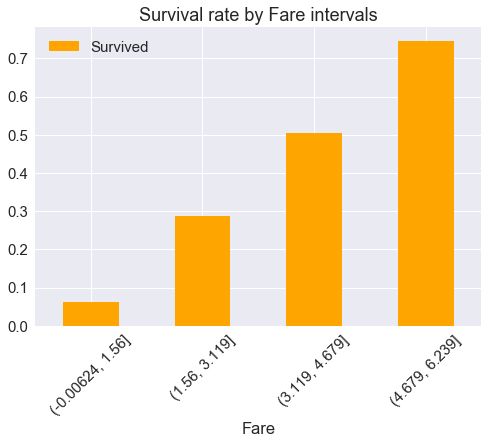

In [27]:
pd.concat([train['Survived'], pd.cut(train['Fare'], 4)], axis=1).groupby(['Fare']).mean().plot.bar(color='orange', rot=45)
plt.title('Survival rate by Fare intervals')

* We verified that survival rate among the intervals differed a lot. 
* It would be better to divide Fare values into several intervals. 

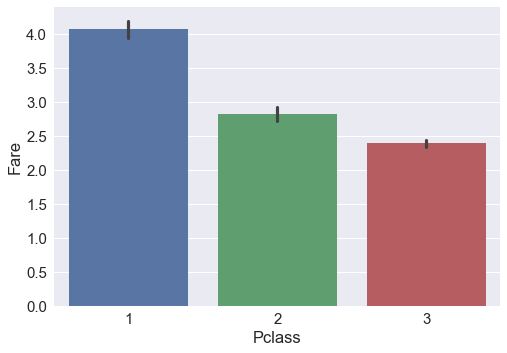

In [28]:
sns.barplot('Pclass', 'Fare', data=train)

* We could also verify that higher class tends to have expensive fare. 

### 2.9 Name

In [29]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

* It is easy to catch that Name values include passengers' title.
* For example, Mr., and Mrs. appeared above. 
* Title is significant information and it is even related to passengers' age.
* I will extract those titles from the original Name column. To extract title, we can utilize the fact that comma is followed by title.

In [30]:
train['Title']=[each[1].split('.')[0].strip() for each in train['Name'].str.split(',')]
test['Title']=[each[1].split('.')[0].strip() for each in test['Name'].str.split(',')]


train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Ms                1
Don               1
Sir               1
Lady              1
the Countess      1
Capt              1
Mme               1
Name: Title, dtype: int64

* Mlle is french word of Miss. Mme is french word of Mrs. 
* Considering above facts, we will divide Title values into Mr, Miss, Mrs, Master, and Rare(which means etc value).

In [31]:
for dataset in data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

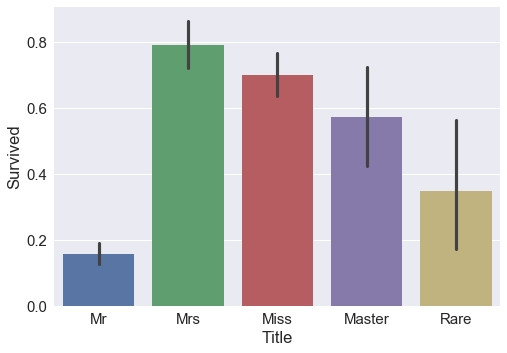

In [32]:
sns.barplot('Title','Survived',data=train)

* Above barplot corresponds with the analysis that female and children passengers were likely to survive more.
* It is shown that Mr(represents male, adult) title passengers survived less than other titles.

## 3. Filling Missing Values

### 3.1 Embarked

In [33]:
print(train['Embarked'].isnull().sum())
train['Embarked'].value_counts()

2


S    644
C    168
Q     77
Name: Embarked, dtype: int64

* There are only 2 missing values in Embarked feature(training data). 
* We can simply replace missing values with the most frequent value of Embarked (S).

In [34]:
train['Embarked']=train['Embarked'].fillna('S')

### 3.2  Age

In [35]:
print(train['Age'].isnull().sum())

177


There are 177 missing values in Age column. Since it is not a small number, we cannot fill them with just mean value, or median value. Here, I would like to replace missing age values using Title feature. Title feature is related to Age, definitely. Mrs usually implies older women, while Miss implies younger women. Also, Mr usually implies older men, while Master implies younger men. 


We can fill missing age values with mean age of the corresponding Title value. 

In [36]:
Title_list=list(train['Title'].unique())

In [37]:
for each in Title_list:
    train.loc[(train['Age'].isnull())&(train['Title']==each), 'Age'] = round(train[['Age', 'Title']].groupby(['Title']).mean().loc[each,'Age'])
    test.loc[(test['Age'].isnull())&(test['Title']==each), 'Age'] = round(test[['Age', 'Title']].groupby(['Title']).mean().loc[each,'Age'])

## 4. Feature Engineering

Until now, we did exploratory data analysis and found some significant correlation with features and response variable. In this feature engineering section, we modify, combine, drop feature variables to maximize our prediction model accuracy. 

In [38]:
train.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
count,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,204,891,891.000000,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3,NaN,5
top,NaN,NaN,NaN,"Cairns, Mr. Alexander",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,NaN,Mr
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,646,NaN,517
mean,446.000000,0.383838,2.308642,NaN,NaN,29.722974,0.523008,0.381594,NaN,2.893846,NaN,NaN,1.904602,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,13.264843,1.102743,0.806057,NaN,1.002899,NaN,NaN,1.613459,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,1.000000,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,2.068177,NaN,NaN,1.000000,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,30.000000,0.000000,0.000000,NaN,2.670985,NaN,NaN,1.000000,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,36.000000,1.000000,0.000000,NaN,3.433987,NaN,NaN,2.000000,NaN


### 4.1 Age feature to categorical

During EDA section, we found some discrete patterns with age levels. For example, passengers younger than 16 years old survived a lot, while passengers older than 16 years old died a lot. Dividing continuous age feature into several discrete levels will be helpful for our model accuracy. I will divide age into 5 levels.

We can use pandas cut method to implement this transformation.

In [39]:
train['Age']=pd.cut(train['Age'],5, labels=[0,1,2,3,4])
test['Age']=pd.cut(test['Age'], 5, labels=[0,1,2,3,4])

### 4.2 Fare feature to categorical

On EDA section, we divided fare values into 4 intervals and found survival rates differ from the intervals. Dividing into several intervals and making it categorical will help our model performance. 

We can use pandas cut method. 

In [40]:
train['Fare']=pd.cut(train['Fare'],4, labels=[0,1,2,3])
test['Fare']=pd.cut(test['Fare'], 4, labels=[0,1,2,3])

### 4.3 FamilySize feature to categorical

Survival rates of 2~4 familysize passengers were similar. Survival rates of 5~7 familysize passengers were also similar. None of passengers with more than 8 family members survived. 

Thus, let's divide familysize into 4 categories; Alone, 2~4, 5~7, more than 8.

In [41]:
train['FamilySize']=train['FamilySize'].map(lambda x: 0 if x == 1 else (1 if x<=4 else (2 if x<=7 else 3)))
test['FamilySize']=test['FamilySize'].map(lambda x: 0 if x == 1 else (1 if x<=4 else (2 if x<=7 else 3)))

### 4.4 Sex feature

Currently, type of sex feature is string. We need to convert these string values into numerical values so that we can use this feature in machine learning method. 

I will map (male,female) into numerical value (1,0).

In [42]:
train['Sex']=train['Sex'].map({'male': 1, 'female':0})
test['Sex']=test['Sex'].map({'male': 1, 'female':0})

### 4.5 One - hot encoding for categorical features

In titanic dataset, there are two kinds of categorical variables. One is ordinal categorical variables, such as Age, Fare, Pclass, FamilySize (Age, Fare features were categorized above). 

These ordinal cateogorical features can be ordered with specific rules. We can handel those with 2 methods. 

One is label encoding, which transforms values into simple numerical values. Order of each level is preserved, but when similar levels have much different survival rates, this method will not help that much. 

The other is one - hot encoding, which creates dummy variables. When similar levels have much different survival rates, this method will help our model accuracy. However, order of each level will be no longer meaningful. 

We need to check every categorical features whether similar levels have similar survival rates or not. For Age, FamilySize, Fare, Pclass, they had quite different survival rate even though each levels are similar. 

Therefore, I will use one - hot encoding for those features. 


The other type of categorical variable is non ordinal categorical variables. In this case, I will use one - hot encoding for these variables. Embarked, Title features are non ordinal categorical variables. 

We can make dummy variables using pandas get_dummies method.

In [43]:
train=pd.concat([train, pd.get_dummies(train['Age'], prefix='Age')], axis=1)
test=pd.concat([test, pd.get_dummies(test['Age'], prefix='Age')], axis=1)

train=pd.concat([train, pd.get_dummies(train['FamilySize'],prefix='FamilySIze')], axis=1)
test=pd.concat([test, pd.get_dummies(test['FamilySize'],prefix='FamilySIze')], axis=1)

train=pd.concat([train, pd.get_dummies(train[['Embarked']])], axis=1)
test=pd.concat([test, pd.get_dummies(test[['Embarked']])], axis=1)

train=pd.concat([train, pd.get_dummies(train[['Title']])], axis=1)
test=pd.concat([test, pd.get_dummies(test[['Title']])], axis=1)

train=pd.concat([train, pd.get_dummies(train['Pclass'], prefix='Pclass')], axis=1)
test=pd.concat([test, pd.get_dummies(test['Pclass'], prefix='Pclass')], axis=1)

train=pd.concat([train, pd.get_dummies(train['Fare'], prefix='Fare')], axis=1)
test=pd.concat([test, pd.get_dummies(test['Fare'], prefix='Fare')], axis=1)

### 4.6 Dropping unnecessary columns

In [44]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'Title',
       'Age_0', 'Age_1', 'Age_2', 'Age_3', 'Age_4', 'FamilySIze_0',
       'FamilySIze_1', 'FamilySIze_2', 'FamilySIze_3', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Fare_0',
       'Fare_1', 'Fare_2', 'Fare_3'],
      dtype='object')

In [45]:
drop_columns=['PassengerId','Name','Age','SibSp','Parch','Ticket','Cabin', 'Embarked','FamilySize', 'Title','Fare','Pclass']
train.drop(drop_columns, axis=1, inplace=True)
test.drop(drop_columns, axis=1, inplace=True)

## 5. Model Selection

For checking model accuracy, we will use 5-fold cross-validation. We can estimate test accuracy using cross-validation checking. 

Here are the models we will use for this problem. For each model, hyperparameter tunning will be done to find the best model. 

* Logistic Regression
* Support Vector Machine
* SGD Classifier
* Random Forest
* Gradient Boosting
* Adaboost
* XGboost

In [46]:
train_X=train[list(train.columns.drop('Survived'))]
train_Y=train['Survived']

In [47]:
train_X.dtypes

Sex             int64
Age_0           uint8
Age_1           uint8
Age_2           uint8
Age_3           uint8
Age_4           uint8
FamilySIze_0    uint8
FamilySIze_1    uint8
FamilySIze_2    uint8
FamilySIze_3    uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
Title_Master    uint8
Title_Miss      uint8
Title_Mr        uint8
Title_Mrs       uint8
Title_Rare      uint8
Pclass_1        uint8
Pclass_2        uint8
Pclass_3        uint8
Fare_0          uint8
Fare_1          uint8
Fare_2          uint8
Fare_3          uint8
dtype: object

In [48]:
# Logistic Regression
lr=LogisticRegression()
print(cross_val_score(lr, train_X, train_Y, cv=5).mean())

0.8215661679410537


In [49]:
# Support Vector Machine
svc=SVC()
svc_param={'kernel': ['linear', 'poly','rbf'], 
           'C': [1,10,20,50,100,200,500,1000], 
          'class_weight':[None, 'balanced']}
svc_grid=GridSearchCV(svc, svc_param, n_jobs=4, cv=5)
svc_grid.fit(train_X, train_Y)
print(svc_grid.best_params_)
print(svc_grid.best_score_)

{'C': 100, 'class_weight': None, 'kernel': 'rbf'}
0.8338945005611672


In [50]:
# SGD Classifier
sgd=SGDClassifier()
print(cross_val_score(sgd, train_X, train_Y, cv=5).mean())

0.7835522328459561


In [51]:
# Random Forest
rf=RandomForestClassifier()
rf_param={'n_estimators':[10, 50, 100, 500, 1000], 
         'min_samples_split': [2,5,10],
          'class_weight':[None, 'balanced']
         }
rf_grid=GridSearchCV(rf, rf_param, n_jobs=4, cv=5)
rf_grid.fit(train_X, train_Y)
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'class_weight': None, 'min_samples_split': 5, 'n_estimators': 100}
0.8204264870931538


In [52]:
# Gradient Boosting
gb=GradientBoostingClassifier()
gb_param={'n_estimators':[100, 500, 1000],
          'learning_rate':[0.01, 0.1, 0.2],
          'max_depth':[3,6,9],
          'min_samples_split': [2,5],
          'max_leaf_nodes':[8,16,32]
         }
gb_grid=GridSearchCV(gb, gb_param, n_jobs=4, cv=5)
gb_grid.fit(train_X, train_Y)
print(gb_grid.best_params_)
print(gb_grid.best_score_)

{'learning_rate': 0.01, 'max_depth': 9, 'max_leaf_nodes': 32, 'min_samples_split': 2, 'n_estimators': 100}
0.8260381593714927


In [53]:
# Xgboost classifier
xgbst=xgb.XGBClassifier()
xgbst_param={'n_estimators':[100, 500, 1000],
          'learning_rate':[0.01, 0.1, 0.2],
          'max_depth':[3,6,9]
         }
xgbst_grid=GridSearchCV(xgbst, xgbst_param, n_jobs=4, cv=5)
xgbst_grid.fit(train_X, train_Y)
print(xgbst_grid.best_params_)
print(xgbst_grid.best_score_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.8260381593714927


In [54]:
# Adaboost classifier
ada=AdaBoostClassifier()
ada_param={'n_estimators':[50, 100, 500, 1000],
          'learning_rate':[0.1, 0.5, 1]
         }
ada_grid=GridSearchCV(ada, ada_param, n_jobs=4, cv=5)
ada_grid.fit(train_X, train_Y)
print(ada_grid.best_params_)
print(ada_grid.best_score_)

{'learning_rate': 0.1, 'n_estimators': 100}
0.8260381593714927


Judging from the cross validation score, support vector machine classifier with parameter {'C': 100, 'class_weight': None, 'kernel': 'rbf'} was the best. I will choose this model to predict test dataset. 

In [55]:
submission=pd.read_csv('gender_submission.csv')

In [57]:
predict=svc_grid.predict(test)
submission['Survived']=predict
submission.to_csv('final_submission.csv', index=False)